In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train.csv', 'sample_submission.csv', 'test.csv']


In [21]:
import seaborn as sns
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


In [3]:
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

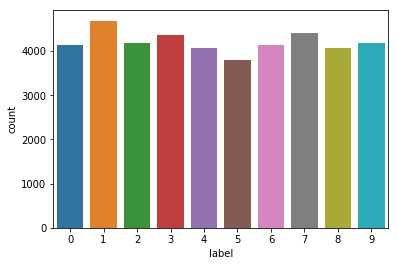

In [4]:
Y_train = train["label"]
X_train = train.drop(labels=["label"], axis = 1)
del train
g = sns.countplot(Y_train)
Y_train.value_counts()

In [5]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [ ]:
test.isnull().any().describe()

In [6]:
X_train = X_train/255.0
test = test / 255.0

In [7]:
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [8]:
print(Y_train[:4])

0    1
1    0
2    1
3    4
Name: label, dtype: int64


In [9]:
Y_train = to_categorical(Y_train, num_classes = 10)

In [10]:
print(Y_train)

[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [11]:
random_seed = 2

In [12]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1,random_state = random_seed)

In [15]:
#g = print(X_train[0][:,:,0])
print("")

In [28]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same', activation = 'relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same', activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2), strides = (2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [35]:
optimizer = RMSprop(lr = 0.001, rho = 0.9, epsilon = 1e-08, decay=0.0)

In [36]:
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])

In [40]:
history = model.fit(X_train, Y_train, batch_size = 86, epochs = 1, validation_data = (X_val, Y_val), verbose = 2)

Train on 37800 samples, validate on 4200 samples
Epoch 1/1
 - 261s - loss: 0.2406 - acc: 0.9233 - val_loss: 0.1124 - val_acc: 0.9650


In order to make the optimizer converge faster and closest to the global minimum of the loss function, i used an annealing method of the learning rate (LR).

The LR is the step by which the optimizer walks through the 'loss landscape'. The higher LR, the bigger are the steps and the quicker is the convergence. However the sampling is very poor with an high LR and the optimizer could probably fall into a local minima.

Its better to have a decreasing learning rate during the training to reach efficiently the global minimum of the loss function.

In [41]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

For the data augmentation, i choosed to :

Randomly rotate some training images by 10 degrees
Randomly Zoom by 10% some training images
Randomly shift images horizontally by 10% of the width
Randomly shift images vertically by 10% of the height
I did not apply a vertical_flip nor horizontal_flip since it could have lead to misclassify symetrical numbers such as 6 and 9.

Once our model is ready, we fit the training dataset .

n order to avoid overfitting problem, we need to expand artificially our handwritten digit dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations occuring when someone is writing a digit.

For example, the number is not centered The scale is not the same (some who write with big/small numbers) The image is rotated...

Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more.

By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

The improvement is important :



In [42]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images
datagen.fit(X_train)

In [45]:
model1 = Sequential()
model1.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same', activation = 'relu', input_shape = (28,28,1)))
model1.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same', activation = 'relu'))
model1.add(MaxPool2D(pool_size = (2,2)))
model1.add(Dropout(0.25))

model1.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation='relu'))
model1.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation = 'relu'))
model1.add(MaxPool2D(pool_size = (2,2), strides = (2,2)))
model1.add(Dropout(0.25))

model1.add(Flatten())
model1.add(Dense(256, activation = "relu"))
model1.add(Dropout(0.5))
model1.add(Dense(10, activation = "softmax"))

In [46]:
model1.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])

In [52]:
history = model1.fit_generator(datagen.flow(X_train,Y_train, batch_size=86),
                              epochs = 5, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // 86
                              , callbacks=[learning_rate_reduction])

Epoch 1/5
 - 297s - loss: 0.4185 - acc: 0.8651 - val_loss: 0.0705 - val_acc: 0.9781
Epoch 2/5
 - 296s - loss: 0.1233 - acc: 0.9624 - val_loss: 0.0361 - val_acc: 0.9876
Epoch 3/5
 - 294s - loss: 0.0907 - acc: 0.9735 - val_loss: 0.0326 - val_acc: 0.9905
Epoch 4/5
 - 301s - loss: 0.0780 - acc: 0.9770 - val_loss: 0.0302 - val_acc: 0.9900
Epoch 5/5
 - 296s - loss: 0.0730 - acc: 0.9782 - val_loss: 0.0527 - val_acc: 0.9862


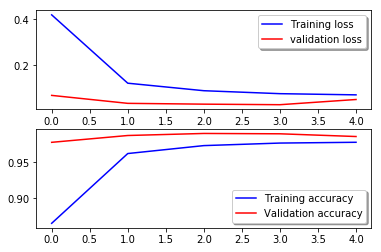

In [53]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [ ]:
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [ ]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_mnist_datagen.csv",index=False)